In [1]:
import torch
from transformers import AutoTokenizer
from transformers.models.llama import LlamaForCausalLM
from transformers.models.llama.modeling_llama import LlamaMLP
from torch.utils.data import DataLoader
from datasets import load_dataset
from TwoSpecHeadsModel import *

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-04-16 17:13:57.593250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744823639.533634    7309 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744823640.091846    7309 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744823644.083235    7309 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744823644.083296    7309 comp

In [2]:
dtype = torch.bfloat16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and base model
tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token

base_model = LlamaForCausalLM.from_pretrained("unsloth/Llama-3.2-1B-Instruct", torch_dtype=dtype)
base_model.to(device)
base_model.eval()


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-0

In [3]:
speculator_head_one = PredictorHead(base_model.model.config)
speculator_head_one.load_state_dict(torch.load("../new_nn_decoder_head1.pth"))
speculator_head_one.to(device, dtype=dtype)

speculator_head_two = PredictorHead(base_model.model.config)
speculator_head_two.load_state_dict(torch.load("second_nn_decoder_head1.pth"))
speculator_head_two.to(device, dtype=dtype)

specModel = ThreeHeadModel(base_model, speculator_head_one, speculator_head_two)
specModel.to(device, dtype=dtype)
specModel.eval()

ThreeHeadModel(
  (base_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(128256, 2048, padding_idx=128004)
      (layers): ModuleList(
        (0-15): 16 x LlamaDecoderLayer(
          (self_attn): LlamaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=512, bias=False)
            (v_proj): Linear(in_features=2048, out_features=512, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          )
          (mlp): LlamaMLP(
            (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
            (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
          (post_attention_layernorm): LlamaRMSNorm((2048,),

In [4]:
class PrefixTuningModel(nn.Module):
    def __init__(self, base_model, speculator_head_one, speculator_head_two, prefix_length):
        """
        Args:
            base_model: The pre-trained LlamaForCausalLM model.
            speculator_head: The additional head (predicting the second token).
            prefix_length: Number of trainable prefix tokens.
        """
        super(PrefixTuningModel, self).__init__()
        self.base_model = base_model
        self.prefix_length = prefix_length
        self.hidden_size = base_model.config.hidden_size
        self.prefix_embeddings = nn.Parameter(torch.randn(prefix_length, self.hidden_size, dtype=dtype))
        self.main_head = base_model.lm_head
        self.speculator_head_one = speculator_head_one
        self.speculator_head_two = speculator_head_two

    def forward(self, input_ids, attention_mask=None):
        batch_size = input_ids.shape[0]
        input_embeds = self.base_model.model.embed_tokens(input_ids)  # shape: [batch, seq_len, hidden_size]
        prefix_embeds = self.prefix_embeddings.unsqueeze(0).expand(batch_size, -1, -1)
        concat_embeds = torch.cat([prefix_embeds, input_embeds], dim=1)
        
        if attention_mask is not None:
            prefix_mask = torch.ones(batch_size, self.prefix_length, device=attention_mask.device)
            attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)
            
        outputs = self.base_model.model(inputs_embeds=concat_embeds, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # shape: [batch, (prefix+seq_len), hidden_size]
        
        logits_main = self.main_head(hidden_states)
        batch_size, seq_len, _ = hidden_states.shape
        
        logits_speculator_one = self.speculator_head_one(hidden_states)
        logits_speculator_two = self.speculator_head_two(hidden_states)
        return logits_main, logits_speculator_one, logits_speculator_two

In [5]:
from torch.optim.lr_scheduler import LinearLR

prefix_length = 8

p_tuning_model = PrefixTuningModel(base_model, speculator_head_one, speculator_head_two, prefix_length)

p_tuning_model.to(device)

for param in p_tuning_model.base_model.parameters():
    param.requires_grad = False
for param in p_tuning_model.speculator_head_one.parameters():
    param.requires_grad = False
for param in p_tuning_model.speculator_head_two.parameters():
    param.requires_grad = False

torch.manual_seed(11786353908476520374)
optimizer = optim.Adam(p_tuning_model.parameters(), lr=1e-3)

torch.manual_seed(11786353908476520374)
criterion = nn.CrossEntropyLoss()
torch.manual_seed(11786353908476520374)


dataset = load_dataset("coqa", split="train")

tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B-Instruct")
tokenizer.pad_token = tokenizer.eos_token

def collate_fn(batch):
    input_ids = [example["input_ids"] for example in batch]
    padded = tokenizer.pad({"input_ids": input_ids}, return_tensors="pt")
    return padded

In [10]:
# dataset = dataset.select(range(8000))

print(len(dataset))


7199


In [17]:
MAX_LENGTH = 128  # Max tokens per sequence
BATCH_SIZE = 8

class MathDataset(Dataset):
    def __init__(self, split="train"): 
        if split == "train":
            self.data = dataset.select(range(0, int(0.9 * len(dataset))))
        else:
            self.data = dataset.select(range(int(0.9 * len(dataset)), len(dataset))) 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]

        # Grab list of questions and answers
        questions = item["questions"]
        answers = item["answers"]["input_text"]

        # Safety: make sure it's not empty and the values are strings
        if not questions or not answers:
            return self.__getitem__((idx + 1) % len(self))  # fallback to another item

        question = str(questions[0])
        answer = str(answers[0])

        encoding = tokenizer(
            question,
            padding="max_length",
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )

        label_encoding = tokenizer(
            answer,
            padding="max_length",
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": label_encoding["input_ids"].squeeze(0),
        }

train_dataset = MathDataset("train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = MathDataset("val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
# trainable params count:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_parameters(p_tuning_model))

Trainable parameters: 16384


In [19]:
import tqdm

batch = next(iter(tqdm.tqdm(train_dataloader)))

print(f"indput_ids: {batch['input_ids'].size()}")
print(f"labels: {batch['labels'].size()}")
print(f"attention_mask: {batch['attention_mask'].size()}")

input_ids = batch['input_ids'].to(device)
labels = batch['labels'].to(device)
attention_mask = batch['attention_mask'].to(device)

specModel.eval()

model_logits_main, model_logits_speculator_one, model_logits_speculator_two = specModel(input_ids, attention_mask)

print(f'main_logits: {model_logits_main.size()}')
print(f'spec_logits_one: {model_logits_speculator_one.size()}')
print(f'spec_logits_two: {model_logits_speculator_two.size()}')


seq_length = input_ids.shape[1]
model_logits_main = model_logits_main[:, -seq_length:, :]
model_logits_speculator_one = model_logits_speculator_one[:, -seq_length:-1, :]


print(f'seq_length: {seq_length}')
print(f'new_logits_main: {model_logits_main.size()}')
print(f'new_logits_spec_one: {model_logits_speculator_one.size()}')

print('first_loss: ')
print(f'{model_logits_main.contiguous().view(-1, model_logits_main.size(-1)).size()}')
print(f'{labels.view(-1).size()}')
      
print('second_loss: ')
print(f'{model_logits_speculator_one.contiguous().view(-1, model_logits_speculator_one.size(-1)).size()}')
print(f'{labels[:, 1:].reshape(-1).size()}')

model_loss_main = criterion(
    model_logits_main.contiguous().view(-1, model_logits_main.size(-1)),
    labels.view(-1)
)
model_loss_head = criterion(
    model_logits_speculator_one.contiguous().view(-1, model_logits_speculator_one.size(-1)),
    labels[:, 1:].reshape(-1)
)

  0%|          | 0/810 [00:00<?, ?it/s]

indput_ids: torch.Size([8, 128])
labels: torch.Size([8, 128])
attention_mask: torch.Size([8, 128])


main_logits: torch.Size([8, 128, 128256])
spec_logits_one: torch.Size([8, 128, 128256])
spec_logits_two: torch.Size([8, 128, 128256])
seq_length: 128
new_logits_main: torch.Size([8, 128, 128256])
new_logits_spec_one: torch.Size([8, 127, 128256])
first_loss: 
torch.Size([1024, 128256])
torch.Size([1024])
second_loss: 
torch.Size([1016, 128256])
torch.Size([1016])


In [20]:
print(batch['input_ids'])


tensor([[128009, 128009, 128009,  ...,    374,  12703,     30],
        [128009, 128009, 128009,  ...,    279,   5818,     30],
        [128009, 128009, 128009,  ...,   1935,   2035,     30],
        ...,
        [128009, 128009, 128009,  ...,  18189,   8631,     30],
        [128009, 128009, 128009,  ...,  54753,   1755,     30],
        [128009, 128009, 128009,  ...,    574,  12800,     30]])


In [21]:
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=3,
    val_every=100,
    draw_every=50,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
):

    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype

    losses = {'train': [], 'val': [], 'accuracy_val': [], 'lr': []}
    # lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)
    start_time = time.monotonic()
    
    # [1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
    idx = 0

    for epoch in range(1, epochs + 1):
        model.train()

        for batch_idx, batch in enumerate(train_dataloader):
            if idx % 10 == 0:
                print(idx)
            idx += 1

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            attention_mask = attention_mask.to(dtype=dtype)

            optimizer.zero_grad()

            model_logits_main, model_logits_speculator_one, model_logits_speculator_two = model(input_ids, attention_mask)

            seq_length = input_ids.shape[1]
            model_logits_main = model_logits_main[:, -seq_length:, :]
            model_logits_speculator_one = model_logits_speculator_one[:, -seq_length:-1, :]
            model_logits_speculator_two = model_logits_speculator_two[:, -seq_length:-2, :]

            model_loss_main = criterion(
                model_logits_main.contiguous().view(-1, model_logits_main.size(-1)),
                labels.view(-1)
            )
            model_loss_head_one = criterion(
                model_logits_speculator_one.contiguous().view(-1, model_logits_speculator_one.size(-1)),
                labels[:, 1:].reshape(-1)
            )
            model_loss_head_two = criterion(
                model_logits_speculator_two.contiguous().view(-1, model_logits_speculator_two.size(-1)),
                labels[:, 2:].reshape(-1)
            )

            if ((idx // 300) % 3 == 0):
                model_loss = model_loss_head_two
            elif ((idx // 300) % 3 == 1):
                model_loss = model_loss_head_one
            else:
                model_loss = model_loss_main
            
            model_loss.backward()
            
            optimizer.step()
            scheduler.step()

            
            current_lr = optimizer.param_groups[0]['lr']
            losses['lr'].append(current_lr)

            losses['train'].append(model_loss_main.item())

            # validation
            if idx % val_every == 0:
                model.eval()

                avg_loss_val = 0.0
                
                agree = 0
                total = 0

                with torch.no_grad():
                    for idx_val, batch in enumerate(val_dataloader):
                        if idx_val == 10:
                            break

                        input_ids = batch["input_ids"].to(device)
                        attention_mask = batch["attention_mask"].to(device)
                        labels = batch["labels"].to(device)

                        attention_mask = attention_mask.to(dtype=dtype)

                        model_logits_main_val, _, _ = model(input_ids, attention_mask)

                        seq_length = input_ids.shape[1]
                        model_logits_main_val = model_logits_main_val[:, -seq_length:, :]

                        val_loss = criterion(
                            model_logits_main_val.contiguous().view(-1, model_logits_main_val.size(-1)),
                            labels.view(-1)
                        ).item()
                        
                        avg_loss_val += val_loss
                        
                        #accuracy computation
                        preds = torch.argmax(model_logits_main_val, dim=-1)
                        
                        agree += (preds == labels).sum().item()
                        total += preds.numel()
                        

                avg_loss_val /= 10

                losses['val'].append(avg_loss_val)
                
                losses['accuracy_val'].append(agree / total if total > 0 else 0)

                torch.cuda.empty_cache()

                model.train()

            # plotting
            if idx % draw_every == 0:
                clear_output(True)
                plt.clf()
                plt.figure(figsize=(10, 5))

                plt.subplot(2, 2, 1)
                plt.plot(losses['train'], label='train_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Training Losses')
                plt.legend()
                plt.grid(True)

                plt.subplot(2, 2, 2)
                plt.plot(losses['val'], label='val_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Validation Losses')
                plt.legend()
                plt.grid(True)

                
                plt.subplot(2, 2, 3)
                plt.plot(losses['accuracy_val'], label='accuracy_val')
                plt.xlabel('Iter')
                plt.ylabel('accuracy')
                plt.title('Validation accuracy')
                plt.legend()
                plt.grid(True)          
                
                plt.subplot(2, 2, 4)
                plt.plot(losses['lr'], label='lr')
                plt.xlabel('Iter')
                plt.ylabel('lr')
                plt.title('learning_rate')
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()

    return losses


In [22]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import LinearLR


num_epochs = 4

total_steps = num_epochs * len(train_dataloader)  # Total training steps

scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0)


In [23]:
print(total_steps)

3240


<Figure size 640x480 with 0 Axes>

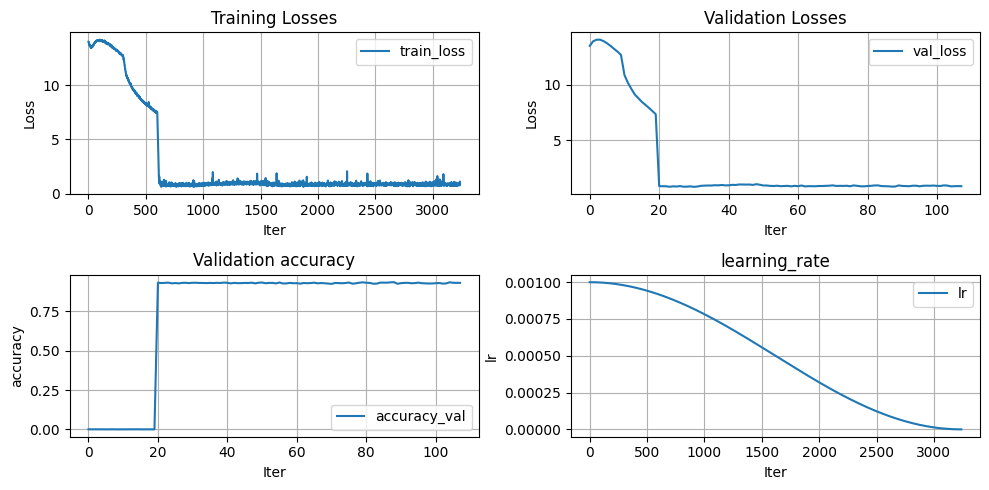

In [24]:
# from torch.optim.lr_scheduler import LinearLR  # Corrected import
import numpy as np

losses = learning_loop(
    p_tuning_model,
    optimizer,
    train_dataloader,
    val_dataloader,
    nn.CrossEntropyLoss(),
    scheduler=scheduler,
    min_lr=None,
    epochs=num_epochs,
    val_every=30,
    draw_every=40,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
)



In [25]:
print(losses['train'])

[14.0, 14.0, 14.0, 14.0, 13.875, 13.8125, 13.75, 13.75, 13.75, 13.6875, 13.75, 13.6875, 13.625, 13.5625, 13.5625, 13.625, 13.625, 13.625, 13.5625, 13.5, 13.5, 13.5625, 13.5625, 13.4375, 13.5, 13.4375, 13.5, 13.5, 13.5, 13.5625, 13.5, 13.5, 13.5, 13.5625, 13.5625, 13.5625, 13.625, 13.5625, 13.625, 13.6875, 13.625, 13.625, 13.6875, 13.6875, 13.75, 13.8125, 13.8125, 13.8125, 13.75, 13.75, 13.875, 13.875, 13.875, 13.875, 13.875, 13.875, 13.875, 13.9375, 13.9375, 14.0, 14.0, 14.0, 13.9375, 14.0, 14.0, 14.0, 14.0625, 14.0, 14.0625, 14.0625, 14.0625, 14.0625, 14.0625, 14.0625, 14.125, 14.0625, 14.125, 14.125, 14.125, 14.125, 14.125, 14.125, 14.125, 14.0625, 14.0625, 14.0625, 14.125, 14.125, 14.125, 14.125, 14.0625, 14.125, 14.0625, 14.125, 14.125, 14.0625, 14.125, 14.1875, 14.1875, 14.125, 14.125, 14.125, 14.125, 14.125, 14.125, 14.125, 14.125, 14.0625, 14.125, 14.125, 14.0625, 14.125, 14.0625, 14.125, 14.125, 14.125, 14.0625, 14.0625, 14.125, 14.125, 14.0625, 14.125, 14.0, 14.0625, 14.0625, 

In [26]:
print(losses['val'])

[13.51875, 13.9375, 14.075, 14.075, 13.94375, 13.75, 13.5125, 13.25, 13.0, 12.7, 10.8875, 10.175, 9.625, 9.1125, 8.7875, 8.4625, 8.19375, 7.928125, 7.640625, 7.34375, 0.842578125, 0.836328125, 0.831640625, 0.78671875, 0.8265625, 0.808984375, 0.849609375, 0.79375, 0.797265625, 0.8265625, 0.778515625, 0.808984375, 0.870703125, 0.88984375, 0.900390625, 0.898046875, 0.926171875, 0.915625, 0.946875, 0.9125, 0.916796875, 0.9609375, 0.949609375, 0.992578125, 0.99140625, 0.984375, 0.989453125, 0.95625, 1.021875, 0.968359375, 0.901171875, 0.901171875, 0.866796875, 0.85546875, 0.882421875, 0.83828125, 0.857421875, 0.869140625, 0.824609375, 0.87265625, 0.837109375, 0.901171875, 0.819140625, 0.844140625, 0.8359375, 0.836328125, 0.856640625, 0.855078125, 0.87109375, 0.883984375, 0.91328125, 0.86015625, 0.871484375, 0.862890625, 0.878125, 0.8375, 0.908984375, 0.8703125, 0.832421875, 0.825390625, 0.85703125, 0.8734375, 0.90546875, 0.91015625, 0.85, 0.837890625, 0.830078125, 0.8015625, 0.81015625, 0.9

In [27]:
print(losses['accuracy_val'])

[0.00048828125, 0.00029296875, 0.000390625, 0.00029296875, 0.00029296875, 0.0, 9.765625e-05, 0.00048828125, 0.0, 0.0, 9.765625e-05, 9.765625e-05, 0.00029296875, 0.000390625, 0.000390625, 0.00029296875, 0.0, 0.00029296875, 9.765625e-05, 9.765625e-05, 0.933203125, 0.93076171875, 0.93212890625, 0.9333984375, 0.92890625, 0.93095703125, 0.9287109375, 0.9322265625, 0.932421875, 0.93076171875, 0.93271484375, 0.93271484375, 0.93134765625, 0.9314453125, 0.9306640625, 0.93173828125, 0.930859375, 0.9322265625, 0.93125, 0.93369140625, 0.932421875, 0.92880859375, 0.9322265625, 0.92998046875, 0.93037109375, 0.9318359375, 0.9310546875, 0.933203125, 0.92890625, 0.9330078125, 0.93408203125, 0.9296875, 0.93173828125, 0.93193359375, 0.928515625, 0.93427734375, 0.928125, 0.92861328125, 0.93193359375, 0.9296875, 0.93017578125, 0.92705078125, 0.93134765625, 0.92978515625, 0.93095703125, 0.93310546875, 0.92919921875, 0.93095703125, 0.92958984375, 0.92763671875, 0.9255859375, 0.9314453125, 0.9306640625, 0.929

In [28]:
print(losses['lr'])

[0.000999999764955713, 0.000999999059823073, 0.0009999978846027431, 0.0009999962392958281, 0.000999994123903875, 0.0009999915384288722, 0.000999988482873251, 0.000999984957239884, 0.0009999809615320856, 0.0009999764957536132, 0.000999971559908665, 0.0009999661540018813, 0.0009999602780383448, 0.0009999539320235803, 0.0009999471159635538, 0.0009999398298646738, 0.0009999320737337902, 0.0009999238475781956, 0.0009999151514056236, 0.0009999059852242506, 0.0009998963490426942, 0.000999886242870014, 0.0009998756667157118, 0.0009998646205897307, 0.0009998531045024566, 0.0009998411184647163, 0.0009998286624877787, 0.000999815736583355, 0.0009998023407635974, 0.0009997884750411006, 0.0009997741394289006, 0.0009997593339404758, 0.0009997440585897456, 0.0009997283133910718, 0.0009997120983592576, 0.000999695413509548, 0.0009996782588576297, 0.000999660634419631, 0.0009996425402121222, 0.000999623976252115, 0.0009996049425570626, 0.0009995854391448605, 0.000999565466033845, 0.0009995450232427945,